In [1]:
from pathlib import Path
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 🔧 Set repo root
REPO_ROOT = Path("/Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection").resolve()
os.chdir(REPO_ROOT)
print("CWD:", Path.cwd())

DATA_DIR = REPO_ROOT / "data/processed"
ART_DIR  = REPO_ROOT / "artifacts"
FIG_DIR  = REPO_ROOT / "docs/figures/models/05_autoencoder"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Processed splits (NO SMOTE)
TRAIN_NOSMOTE = DATA_DIR / "train_nosmote.csv"
VAL_NOSMOTE   = DATA_DIR / "val_nosmote.csv"
TEST_NOSMOTE  = DATA_DIR / "test_nosmote.csv"

# AE artifacts (existing)
AE_MODEL_H5   = ART_DIR / "autoencoder_model.h5"
AE_MODEL_KERAS= ART_DIR / "autoencoder_model.keras"
AE_THRESH_TXT = ART_DIR / "ae_threshold.txt"
AE_THRESH_JSON= ART_DIR / "ae_thresholds.json"
AE_METRICS    = ART_DIR / "ae_metrics.json"
AE_BASELINE   = ART_DIR / "ae_baseline_legit_errors.npy"

print("TRAIN_NOSMOTE exists:", TRAIN_NOSMOTE.exists())
print("VAL_NOSMOTE exists  :", VAL_NOSMOTE.exists())
print("TEST_NOSMOTE exists :", TEST_NOSMOTE.exists())
print("AE model h5 exists  :", AE_MODEL_H5.exists())
print("AE model keras exists:", AE_MODEL_KERAS.exists())
print("FIG_DIR:", FIG_DIR)


CWD: /Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection
TRAIN_NOSMOTE exists: True
VAL_NOSMOTE exists  : True
TEST_NOSMOTE exists : True
AE model h5 exists  : True
AE model keras exists: True
FIG_DIR: /Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection/docs/figures/models/05_autoencoder


In [2]:
def load_processed(path: Path, target_col: str = "Class"):
    df = pd.read_csv(path)
    y = df[target_col].astype(int).values
    X = df.drop(columns=[target_col]).values
    cols = df.drop(columns=[target_col]).columns.astype(str).tolist()
    return df, X, y, cols

train_df, X_train, y_train, feat_cols = load_processed(TRAIN_NOSMOTE)
val_df, X_val, y_val, _ = load_processed(VAL_NOSMOTE)
test_df, X_test, y_test, _ = load_processed(TEST_NOSMOTE)

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)
print("Fraud counts:", int(y_train.sum()), int(y_val.sum()), int(y_test.sum()))


Shapes: (199364, 102) (42721, 102) (42722, 102)
Fraud counts: 384 56 52


In [3]:
X_train_legit = X_train[y_train == 0]
print("Train legit-only shape:", X_train_legit.shape)


Train legit-only shape: (198980, 102)


In [4]:
import tensorflow as tf
from tensorflow import keras

def load_ae_model():
    if AE_MODEL_KERAS.exists():
        return keras.models.load_model(AE_MODEL_KERAS)
    if AE_MODEL_H5.exists():
        return keras.models.load_model(AE_MODEL_H5)
    raise FileNotFoundError("No AE model found in artifacts/. Expected autoencoder_model.keras or .h5")

def load_threshold():
    if AE_THRESH_TXT.exists():
        t = float(AE_THRESH_TXT.read_text().strip())
        return t, "ae_threshold.txt"
    if AE_THRESH_JSON.exists():
        j = json.loads(AE_THRESH_JSON.read_text())
        # common keys: threshold, p95, p99 etc.
        if "threshold" in j:
            return float(j["threshold"]), "ae_thresholds.json:threshold"
        # fallback: pick p99 if present
        for k in ["p99", "p995", "p95"]:
            if k in j:
                return float(j[k]), f"ae_thresholds.json:{k}"
    raise FileNotFoundError("No threshold found. Expected ae_threshold.txt or ae_thresholds.json")

ae = load_ae_model()
threshold, thr_source = load_threshold()

print("Loaded AE:", type(ae))
print("Threshold:", threshold, "from", thr_source)


2025-12-24 21:32:10.776416: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-12-24 21:32:10.776447: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-12-24 21:32:10.776452: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-12-24 21:32:10.776473: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-24 21:32:10.776485: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Loaded AE: <class 'keras.src.models.functional.Functional'>
Threshold: 2.413630972099965 from ae_threshold.txt


In [5]:
def recon_error(model, X: np.ndarray, batch_size: int = 1024) -> np.ndarray:
    X_hat = model.predict(X, batch_size=batch_size, verbose=0)
    # MSE per row
    err = np.mean((X - X_hat) ** 2, axis=1)
    return err


In [6]:
err_train = recon_error(ae, X_train)
err_val   = recon_error(ae, X_val)
err_test  = recon_error(ae, X_test)

pred_val  = (err_val  >= threshold).astype(int)
pred_test = (err_test >= threshold).astype(int)

print("Error ranges:")
print(" train:", float(err_train.min()), float(err_train.mean()), float(err_train.max()))
print(" val  :", float(err_val.min()), float(err_val.mean()), float(err_val.max()))
print(" test :", float(err_test.min()), float(err_test.mean()), float(err_test.max()))


2025-12-24 21:32:22.875690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Error ranges:
 train: 0.056260175477385835 0.3187789136762249 299.41946839405284
 val  : 0.06399265810324863 0.3527755014412536 129.49988841062802
 test : 0.06435823772100709 0.29932228850372483 638.7639745507751


In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, confusion_matrix, roc_auc_score

def eval_scores(y_true, y_pred, score, name: str):
    cm = confusion_matrix(y_true, y_pred)
    p = precision_score(y_true, y_pred, zero_division=0)
    r = recall_score(y_true, y_pred, zero_division=0)
    f = f1_score(y_true, y_pred, zero_division=0)
    ap = average_precision_score(y_true, score)
    auc = roc_auc_score(y_true, score)
    print(f"\n{name}")
    print("CM [[TN,FP],[FN,TP]] =", cm.tolist())
    print(f"precision={p:.3f} recall={r:.3f} f1={f:.3f} AP={ap:.3f} AUC={auc:.3f}")
    return {"cm": cm.tolist(), "precision": p, "recall": r, "f1": f, "ap": ap, "auc": auc}

# For score: higher error => more fraud-like
m_val  = eval_scores(y_val,  pred_val,  err_val,  f"VAL @ thr={threshold:.6f}")
m_test = eval_scores(y_test, pred_test, err_test, f"TEST @ thr={threshold:.6f}")



VAL @ thr=2.413631
CM [[TN,FP],[FN,TP]] = [[42150, 515], [32, 24]]
precision=0.045 recall=0.429 f1=0.081 AP=0.029 AUC=0.945

TEST @ thr=2.413631
CM [[TN,FP],[FN,TP]] = [[42362, 308], [29, 23]]
precision=0.069 recall=0.442 f1=0.120 AP=0.045 AUC=0.927


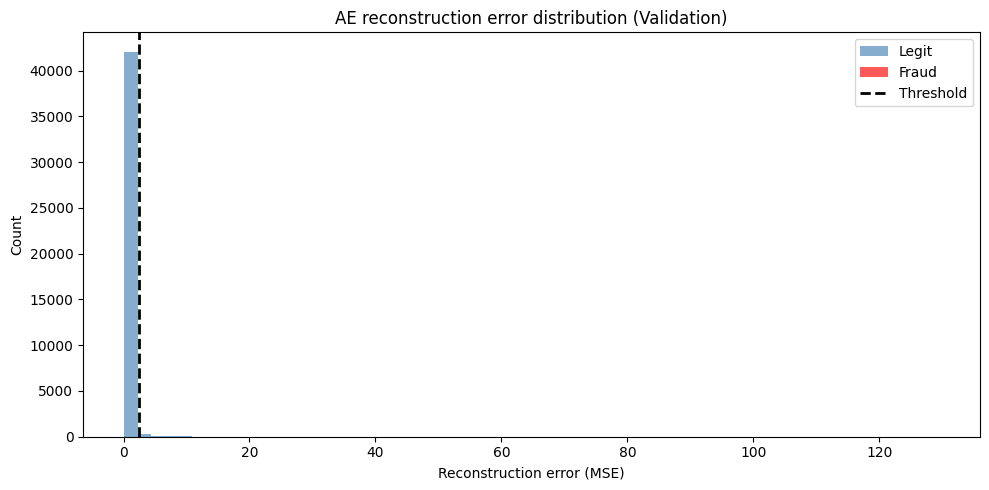

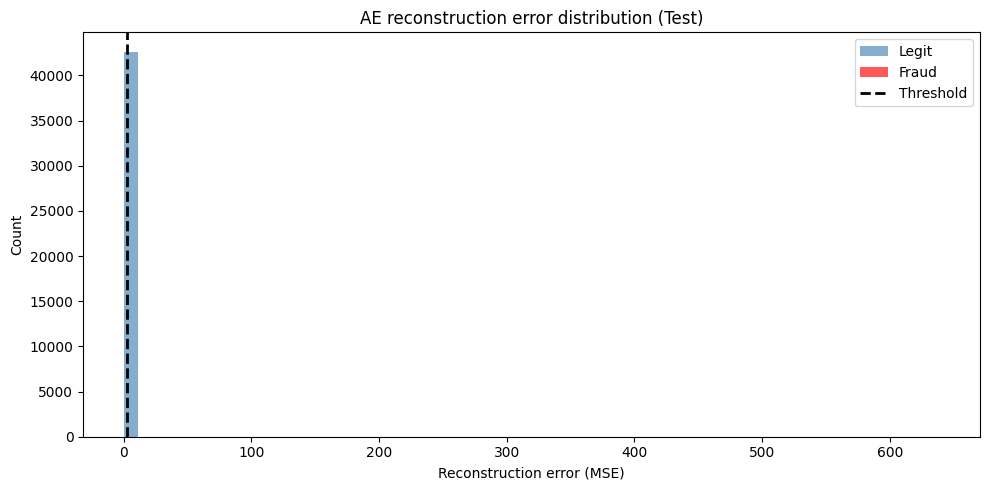

In [8]:
import numpy as np

def plot_error_distribution(errors, y, title, outpath: Path):
    legit = errors[y == 0]
    fraud = errors[y == 1]

    plt.figure(figsize=(10,5))
    plt.hist(legit, bins=60, alpha=0.65, label="Legit", color="steelblue")
    plt.hist(fraud, bins=60, alpha=0.65, label="Fraud", color="red")
    plt.axvline(threshold, linestyle="--", linewidth=2, color="black", label="Threshold")
    plt.title(title)
    plt.xlabel("Reconstruction error (MSE)")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()
    plt.close()

plot_error_distribution(err_val, y_val, "AE reconstruction error distribution (Validation)", FIG_DIR / "ae_error_dist_val.png")
plot_error_distribution(err_test, y_test, "AE reconstruction error distribution (Test)", FIG_DIR / "ae_error_dist_test.png")


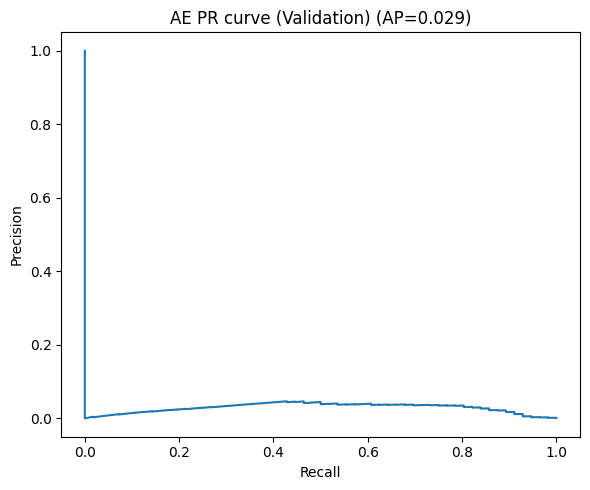

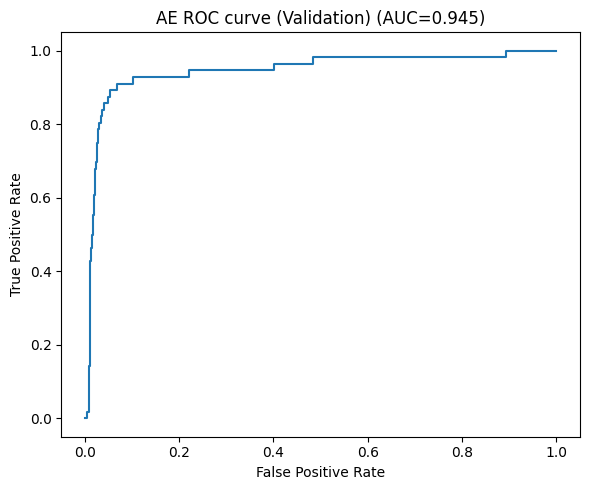

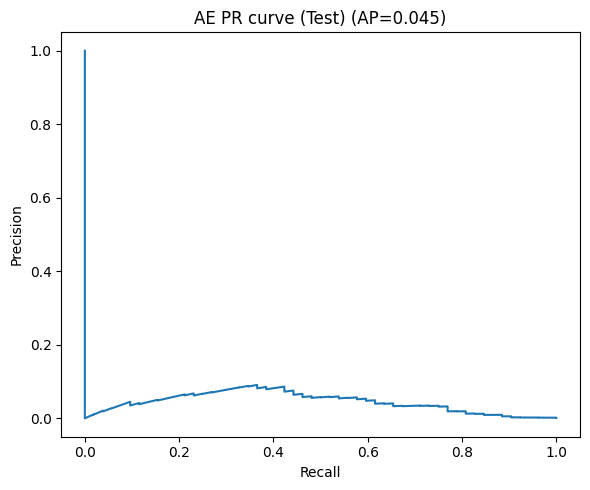

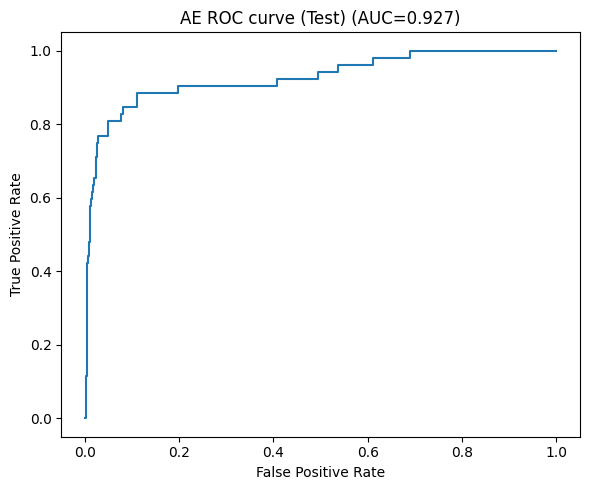

In [9]:
from sklearn.metrics import precision_recall_curve, roc_curve

def plot_pr_curve(y, score, title, outpath: Path):
    precision, recall, _ = precision_recall_curve(y, score)
    ap = average_precision_score(y, score)

    plt.figure(figsize=(6,5))
    plt.plot(recall, precision)
    plt.title(f"{title} (AP={ap:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()
    plt.close()

def plot_roc_curve(y, score, title, outpath: Path):
    fpr, tpr, _ = roc_curve(y, score)
    auc = roc_auc_score(y, score)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr)
    plt.title(f"{title} (AUC={auc:.3f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()
    plt.close()

plot_pr_curve(y_val, err_val, "AE PR curve (Validation)", FIG_DIR / "ae_pr_val.png")
plot_roc_curve(y_val, err_val, "AE ROC curve (Validation)", FIG_DIR / "ae_roc_val.png")

plot_pr_curve(y_test, err_test, "AE PR curve (Test)", FIG_DIR / "ae_pr_test.png")
plot_roc_curve(y_test, err_test, "AE ROC curve (Test)", FIG_DIR / "ae_roc_test.png")


In [10]:
summary = {
    "threshold": threshold,
    "threshold_source": thr_source,
    "val": m_val,
    "test": m_test,
    "figures_saved_to": str(FIG_DIR.relative_to(REPO_ROOT)),
}

out = FIG_DIR / "ae_eval_summary.json"
out.write_text(json.dumps(summary, indent=2), encoding="utf-8")
print("Saved:", out)
print(json.dumps(summary, indent=2))


Saved: /Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection/docs/figures/models/05_autoencoder/ae_eval_summary.json
{
  "threshold": 2.413630972099965,
  "threshold_source": "ae_threshold.txt",
  "val": {
    "cm": [
      [
        42150,
        515
      ],
      [
        32,
        24
      ]
    ],
    "precision": 0.04452690166975881,
    "recall": 0.42857142857142855,
    "f1": 0.08067226890756303,
    "ap": 0.028938196149506382,
    "auc": 0.9453797023321224
  },
  "test": {
    "cm": [
      [
        42362,
        308
      ],
      [
        29,
        23
      ]
    ],
    "precision": 0.06948640483383686,
    "recall": 0.4423076923076923,
    "f1": 0.12010443864229765,
    "ap": 0.044535622758506796,
    "auc": 0.9271448144075283
  },
  "figures_saved_to": "docs/figures/models/05_autoencoder"
}
